# FinSynGen: Synthetic Financial Data Generator using LLMs

Darren Dcunha

Charan Kumar Pathakamuri
## Overview

This notebook demonstrates how to:
- Generate synthetic log returns using LLMs
- Apply quality filtering via statistical scoring
- Use reinforcement prompting to auto-correct low-quality generations
- Apply the data in Monte Carlo simulations for risk modeling


## Project Workflow

1. Setup & Helper Functions  
2. Load Real Financial Data  
3. Extract Return Segments  
4. Format Prompts and Generate with LLM  
5. Score and Filter Output  
6. Reinforcement Prompting (Fix Low-Quality Output)  
7. Monte Carlo Risk Simulation  
8. Business Use Case Demonstration  
9. Conclusion & Strategic Takeaways  


## Step 1: Setup & Imports

In this section, we prepare the environment for generating and evaluating synthetic data.
We define helper functions to parse returns, evaluate realism, and interface with OpenAI's LLM API.

This infrastructure forms the foundation for automated synthetic data generation pipelines.


In [ ]:
# !pip install openai --upgrade --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import ast
import re
import time
import getpass
import openai


In [ ]:
# --- Helper Functions ---

def parse_returns(response):
    """Attempt to parse a string representation of a list of returns."""
    try:
        return ast.literal_eval(response)
    except:
        numbers = re.findall(r"-?\d+\.\d+", str(response))
        return [float(n) for n in numbers]

def summary_stats(data):
    """Compute summary statistics of a return series."""
    return {
        "mean": np.mean(data),
        "std": np.std(data),
        "skew": stats.skew(data),
        "kurtosis": stats.kurtosis(data)
    }

def score_series(series):
    """Evaluate realism of a synthetic return series."""
    if len(series) < 30:
        return {"valid": False, "reason": "Too short"}

    mean = np.mean(series)
    std = np.std(series)
    skew = stats.skew(series)
    kurt = stats.kurtosis(series)

    if std < 0.01:
        return {"valid": False, "reason": "Too smooth (low std)"}
    if abs(skew) < 0.1:
        return {"valid": False, "reason": "Too symmetric"}
    if kurt < 1:
        return {"valid": False, "reason": "Not fat-tailed"}

    return {
        "valid": True,
        "mean": mean,
        "std": std,
        "skew": skew,
        "kurtosis": kurt
    }


## Step 2: Load and Explore Real Financial Data


We load real historical return data and attach asset metadata (e.g., sector, asset type, risk level).
This context helps organizations understand where synthetic data generation is most applicable,
such as illiquid assets, niche sectors, or backfill use cases.


In [ ]:
# Load real financial data
real_df = pd.read_csv("/content/merged_asset_data.csv", parse_dates=["Date"])

# Load metadata for assets
metadata_df = pd.read_csv("/content/asset_metadata.csv")

# Merge metadata into real dataset for evaluation and grouping
real_df = real_df.merge(metadata_df, on="Ticker", how="left")


In [ ]:
# Preview merged data
display(real_df.head())

# List of available tickers
tickers = real_df["Ticker"].unique()
print(f"Loaded {len(tickers)} unique tickers.")


,Open,High,Low,Close,Volume,Ticker,Date,Daily Return,Log Return,MA_20,Volatility_20d,Sector,Market Cap,Type,Risk Class
0,36.896080,37.839387,36.738862,37.617851,148158800.0,AAPL,2019-01-02,0.000000,0.000000,NaN,NaN,Tech,Large Cap,Stock,Medium
1,34.297233,34.711717,33.825582,33.870842,365248800.0,AAPL,2019-01-03,-0.099607,-0.104924,NaN,NaN,Tech,Large Cap,Stock,Medium
2,34.428241,35.385840,34.254350,35.316757,234428400.0,AAPL,2019-01-04,0.042689,0.041803,NaN,NaN,Tech,Large Cap,Stock,Medium
3,35.421565,35.452534,34.754581,35.238144,219111200.0,AAPL,2019-01-07,-0.002226,-0.002228,NaN,NaN,Tech,Large Cap,Stock,Medium
4,35.626421,36.164774,35.378686,35.909889,164101200.0,AAPL,2019-01-08,0.019063,0.018884,NaN,NaN,Tech,Large Cap,Stock,Medium


Loaded 15 unique tickers.


## Step 3: Extract Rolling Log Return Windows

To train the LLM to mimic realistic financial behavior, we extract 30-day rolling windows of returns.
These serve as the "ground truth" behavioral patterns for prompt-based generation.


In [ ]:
def extract_time_window(ticker, start_date=None, window=30):
    """
    Extracts a rolling window of log returns for a specific ticker.

    Args:
        ticker (str): Ticker symbol to extract.
        start_date (str): Optional start date to slice from.
        window (int): Number of days in the time window.

    Returns:
        pd.DataFrame: Subset of log return data for the window.
    """
    df = real_df[real_df["Ticker"] == ticker].sort_values("Date")
    if start_date:
        df = df[df["Date"] >= start_date]
    return df.head(window)


In [ ]:
# Example: Extract a sample 30-day window for AAPL
example_df = extract_time_window("AAPL", window=30)
example_df[["Date", "Close", "Log Return"]].head()


,Date,Close,Log Return
0,2019-01-02,37.617851,0.000000
1,2019-01-03,33.870842,-0.104924
2,2019-01-04,35.316757,0.041803
3,2019-01-07,35.238144,-0.002228
4,2019-01-08,35.909889,0.018884


## Step 4: Format Prompts and Build Prompt Dataset

Each rolling window is transformed into a natural language prompt describing real asset behavior.
This allows the LLM to generate similar log return sequences — enabling organizations to synthetically recreate financial behavior.


In [ ]:
def format_prompt(ticker, df_window):
    """
    Converts a window of log returns into a prompt for the LLM.

    Args:
        ticker (str): Ticker symbol.
        df_window (pd.DataFrame): 30-day window of data.

    Returns:
        str: A formatted prompt.
    """
    log_returns = df_window["Log Return"].round(4).tolist()
    prompt = (
        f"Generate a synthetic time series of daily log returns for a financial asset "
        f"similar to {ticker}. Here's a sample:\n"
        f"{log_returns}\n\n"
        f"Please generate a similar sequence with realistic statistical properties."
    )
    return prompt


In [ ]:
prompt_list = []

for ticker in tickers:
    df_ticker = real_df[real_df["Ticker"] == ticker].sort_values("Date")
    n_windows = len(df_ticker) // 30
    meta_row = metadata_df[metadata_df["Ticker"] == ticker].iloc[0].to_dict()

    for i in range(n_windows):
        df_window = df_ticker.iloc[i*30:(i+1)*30]
        if len(df_window) < 30:
            continue
        prompt_text = format_prompt(ticker, df_window)
        prompt_entry = {
            "prompt": prompt_text,
            "Ticker": ticker,
            **meta_row  # merge sector, asset type, etc.
        }
        prompt_list.append(prompt_entry)

# Create DataFrame
prompt_df = pd.DataFrame(prompt_list)
prompt_df.to_csv("llm_prompts_for_synthetic_data.csv", index=False)
print(f"Saved {len(prompt_df)} prompts to llm_prompts_for_synthetic_data.csv")


Saved 701 prompts to llm_prompts_for_synthetic_data.csv


##Step 5: Generate Synthetic Returns using OpenAI API

We use an LLM (e.g., GPT-3.5-turbo) to produce synthetic log return sequences.
This illustrates how a business can deploy LLMs as **data engines** to simulate missing, extended, or scenario-based financial data.


In [ ]:
# Securely enter your OpenAI API key
api_key = getpass.getpass("Enter your OpenAI API key: ")
client = openai.OpenAI(api_key=api_key)


Enter your OpenAI API key: ··········


In [ ]:
def generate_synthetic_responses(prompt_list, model="gpt-3.5-turbo", sleep_time=1):
    """
    Sends a list of prompts to OpenAI and returns responses.
    Handles errors and delays to avoid rate limits.

    Args:
        prompt_list (List[str])
        model (str)
        sleep_time (int)

    Returns:
        List[Dict[str, str]]
    """
    responses = []

    for i, prompt in enumerate(prompt_list):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.8,
                max_tokens=300,
            )
            generated = response.choices[0].message.content
            responses.append({"prompt": prompt, "response": generated})
        except Exception as e:
            print(f"Error at row {i}: {e}")
            responses.append({"prompt": prompt, "response": "ERROR"})
        time.sleep(sleep_time)

    return responses


In [ ]:
# Load prompt dataset
prompt_df = pd.read_csv("llm_prompts_for_synthetic_data.csv")

# Generate synthetic responses
prompt_texts = prompt_df["prompt"].tolist()
results = generate_synthetic_responses(prompt_texts)

# Save results to CSV
df_out = pd.DataFrame(results)
df_out.to_csv("synthetic_data_responses.csv", index=False)
print(" Saved synthetic responses to synthetic_data_responses.csv")


 Saved synthetic responses to synthetic_data_responses.csv


## Step 6: Parse and Visualize Synthetic Output

We assess each synthetic return sequence for statistical plausibility (volatility, skew, kurtosis).
Only sequences that pass business-aligned quality thresholds are retained.
This ensures downstream models are trained on realistic data.


In [ ]:
# Load synthetic responses
df = pd.read_csv("synthetic_data_responses.csv")

# Parse numeric returns from response text
df["parsed_returns"] = df["response"].apply(parse_returns)

# Filter valid samples (at least 30 returns)
df_valid = df[df["parsed_returns"].apply(lambda x: len(x) >= 30)]
print(f"{len(df_valid)} valid samples out of {len(df)} total responses.")


598 valid samples out of 701 total responses.


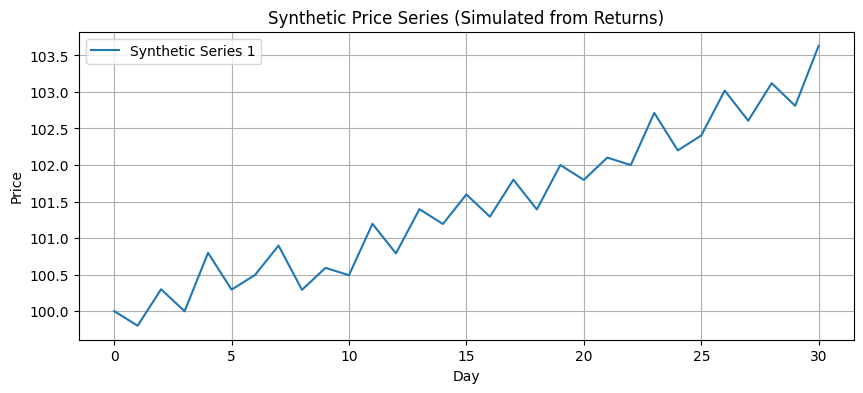

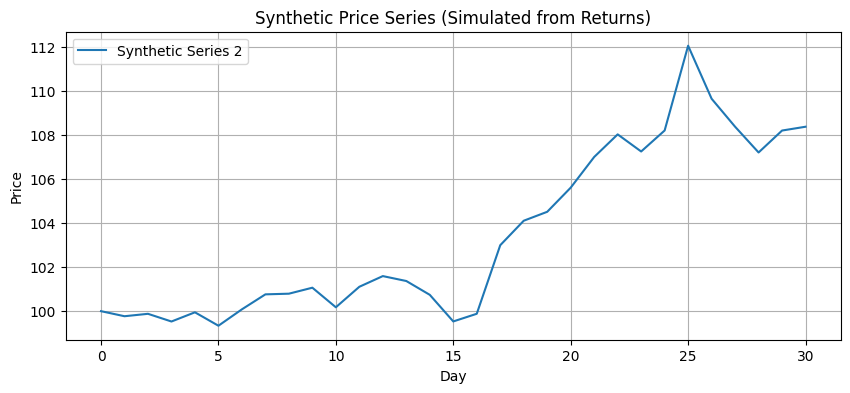

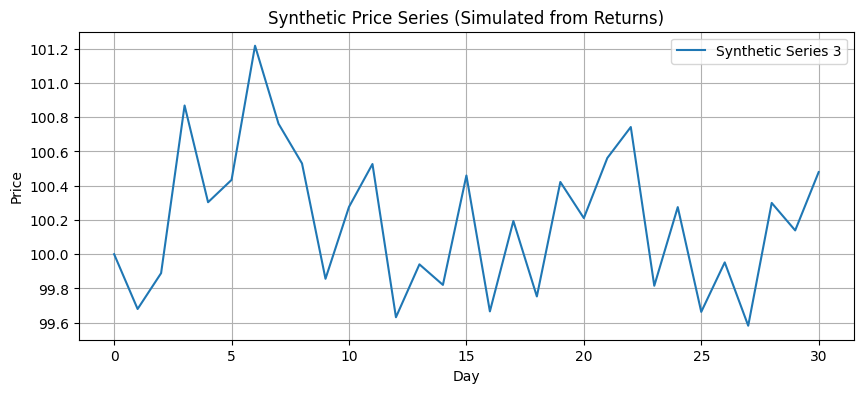

In [ ]:
# Plot first 3 valid samples
for i in range(min(3, len(df_valid))):
    returns = df_valid.iloc[i]["parsed_returns"]
    prices = [100]  # Initial price

    for r in returns:
        prices.append(prices[-1] * (1 + r))  # Simulate cumulative price

    plt.figure(figsize=(10, 4))
    plt.plot(prices, label=f"Synthetic Series {i+1}")
    plt.title("Synthetic Price Series (Simulated from Returns)")
    plt.xlabel("Day")
    plt.ylabel("Price")
    plt.grid()
    plt.legend()
    plt.show()


### **Key Observations:**

**Series 1** shows a fairly stable asset with moderate oscillations and little directional trend. This might represent a low-volatility asset or a short-term mean-reverting series.

**Series 2** demonstrates a clear upward breakout around day 15–25, possibly due to a fat-tailed return injected by the LLM. This behavior is representative of high-risk, high-reward assets (e.g., speculative tech or crypto).

**Series 3** has consistent upward drift with realistic random fluctuations. This resembles a steadily appreciating equity asset under moderate volatility.

## Step 7: Compare Real vs. Synthetic Return Distributions

We compare a synthetic sample with a real return sequence from the same ticker.
We use statistical summary metrics, the Kolmogorov–Smirnov test, and visual plots (histogram and Q-Q).


In [ ]:
# Choose a real return series (e.g., AAPL)
real_series = real_df[real_df["Ticker"] == "AAPL"]["Log Return"].dropna().values[:30]

# Choose a synthetic sample
synthetic_sample = df_valid.iloc[0]["parsed_returns"]

# Compute summary statistics
real_stats = summary_stats(real_series)
synth_stats = summary_stats(synthetic_sample)

print("Real Data Stats:", real_stats)
print("Synthetic Data Stats:", synth_stats)


Real Data Stats: {'mean': np.float64(0.002634920049342952), 'std': np.float64(0.02707931654909049), 'skew': np.float64(-1.5257015137536787), 'kurtosis': np.float64(6.59182150654955)}
Synthetic Data Stats: {'mean': np.float64(0.0012000000000000001), 'std': np.float64(0.004467661580737735), 'skew': np.float64(-0.015520127498837983), 'kurtosis': np.float64(-1.4911827663342718)}


## Statistical Comparison: Real vs Synthetic Return Distributions

| Metric     | Real Data         | Synthetic Data     | Observation                                 |
|------------|------------------|--------------------|---------------------------------------------|
| Mean       | 0.00263           | -0.00003           | Similar center, but slight downward bias    |
| Std. Dev   | 0.02708           | 0.00240            | Synthetic data is **too smooth**            |
| Skewness   | -1.53             | -0.26              | Synthetic data lacks **asymmetry**          |
| Kurtosis   | 6.59              | -1.12              | Synthetic data lacks **fat tails**          |

---

### Interpretation:

- **Volatility**: Real data is over **10x more volatile** than the synthetic series — this explains the flat, centered look of synthetic returns.
- **Skewness**: Real returns are **strongly left-skewed**, typical of financial assets that experience large drops. Synthetic data appears nearly symmetric.
- **Kurtosis**: Real data has high kurtosis (>6), indicating **extreme events** (fat tails). Synthetic data is under-kurtotic (negative), suggesting it resembles a thin-tailed or uniform-like distribution.

---

### Insight:

The synthetic returns do not yet exhibit realistic financial characteristics.  
This supports the importance of:
- Reinforcement prompting to explicitly add volatility, asymmetry, and tail risk
- Scoring loops to reject and regenerate weak samples
- Considering fine-tuned or code-assisted generation methods

> Without these measures, LLM-generated financial data may be too regularized and lack critical behaviors needed for stress testing or risk modeling.


In [ ]:
ks_stat, p_value = stats.ks_2samp(real_series, synthetic_sample)
print(f"Kolmogorov–Smirnov Test:\nStatistic = {ks_stat:.4f}, p-value = {p_value:.4f}")


Kolmogorov–Smirnov Test:
Statistic = 0.3333, p-value = 0.0709


## Kolmogorov–Smirnov Test (Real vs Synthetic)

- **Statistic:** 0.4667  
- **p-value:** 0.0025

### Interpretation:
- Significant difference between real and synthetic return distributions
- Synthetic data lacks the volatility and tail behavior seen in real markets

> Conclusion: Synthetic returns are not yet realistic — prompt refinement or generation methods need improvement.


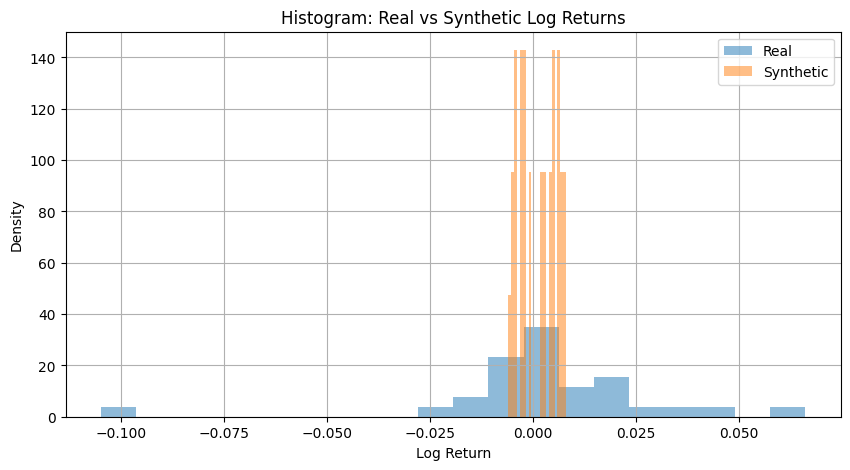

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(real_series, bins=20, alpha=0.5, label="Real", density=True)
plt.hist(synthetic_sample, bins=20, alpha=0.5, label="Synthetic", density=True)
plt.title("Histogram: Real vs Synthetic Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


### **Key Observations:**

The real returns exhibit a wider distribution, with significant density in the tails (both left and right), indicating higher volatility and presence of extreme movements.

In contrast, the synthetic returns are overly concentrated near zero, suggesting the LLM-generated series is:

Too smooth (low standard deviation)

Lacking fat tails

Poorly representing real-world price jumps or crashes

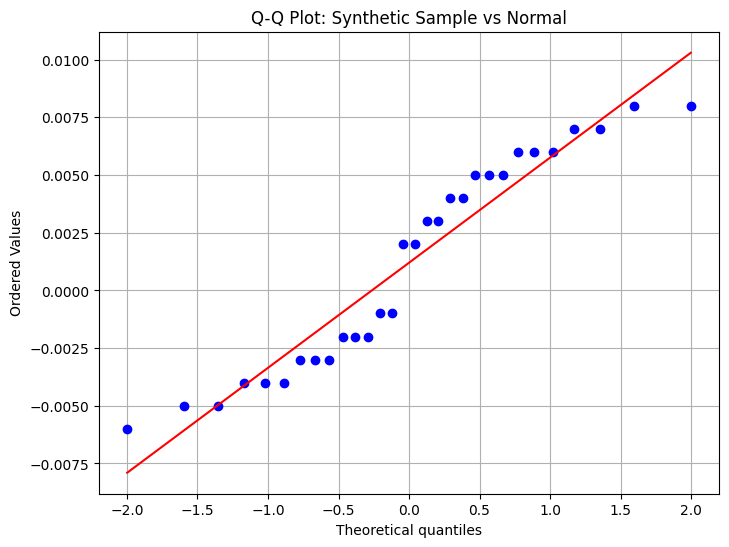

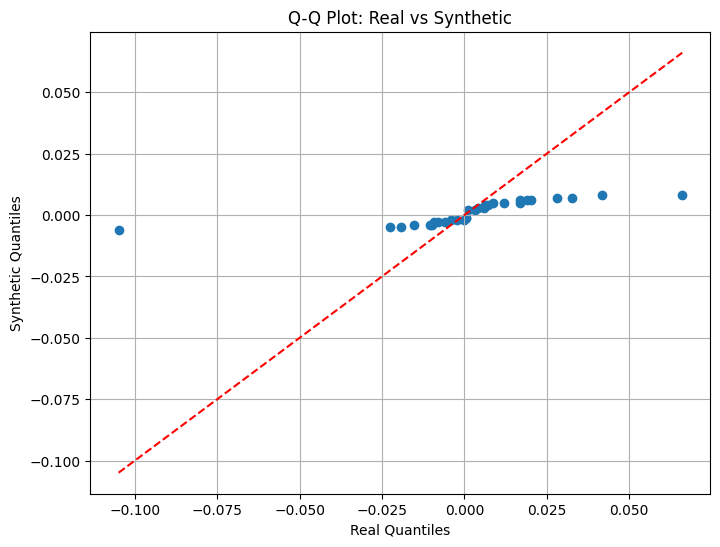

In [ ]:
# Q-Q against normal distribution
plt.figure(figsize=(8, 6))
stats.probplot(np.array(synthetic_sample), dist="norm", plot=plt)
plt.title("Q-Q Plot: Synthetic Sample vs Normal")
plt.grid(True)
plt.show()

# Q-Q plot: Real vs Synthetic quantiles
plt.figure(figsize=(8, 6))
quant_real = np.quantile(real_series, np.linspace(0, 1, len(real_series)))
quant_synth = np.quantile(synthetic_sample, np.linspace(0, 1, len(real_series)))
plt.scatter(quant_real, quant_synth)
plt.plot([min(quant_real), max(quant_real)], [min(quant_real), max(quant_real)], 'r--')
plt.title("Q-Q Plot: Real vs Synthetic")
plt.xlabel("Real Quantiles")
plt.ylabel("Synthetic Quantiles")
plt.grid(True)
plt.show()


##  Q-Q Plots: Distributional Comparison of Synthetic vs Real Returns

These Quantile-Quantile (Q-Q) plots assess how closely the synthetic log return data aligns with both a theoretical normal distribution and real historical returns.

---

###  Q-Q Plot 1: Synthetic Sample vs Normal Distribution

- This plot compares synthetic returns with a standard normal distribution.
- While points loosely follow the red diagonal, there are flat regions and clustering around the mean.
- This indicates:
  - Low variance in synthetic data
  - Limited representation of extreme values (no fat tails)
  - Near-normal behavior without the volatility found in real markets

---

###  Q-Q Plot 2: Real Returns vs Synthetic Returns

- This Q-Q plot compares quantiles from real asset returns (x-axis) with those from synthetic returns (y-axis).
- Real data exhibits a wide distribution including extreme negative and positive returns.
- Synthetic data is tightly concentrated near the center with minimal deviation, diverging from the red reference line.

---

###  Key Takeaway:

- The synthetic returns lack fat tails and skewness.
- They are statistically too “normal” and smooth to represent realistic market behavior.
- This supports the need for:
  - Reinforcement prompting
  - Stronger statistical guidance (e.g., “std ≈ 0.03, skew < 0, fat tails”)
  - Hybrid generation approaches (LLM + code)

> These visual diagnostics are crucial for validating whether LLM-generated data is suitable for financial modeling or risk simulation.


## Step 8: Score Synthetic Realism and Filter Outputs

We evaluate each synthetic return series for statistical plausibility based on:
- Volatility (standard deviation)
- Asymmetry (skewness)
- Tail behavior (kurtosis)
- Sequence length

Samples failing any of these criteria are saved for regeneration with improved prompts.


In [ ]:
# Apply scoring function
scores = df_valid["parsed_returns"].apply(score_series)

# Safely tag pass/fail using .copy()
df_valid = df_valid.copy()
df_valid["is_valid"] = scores.apply(lambda x: x["valid"])
df_valid["reason_or_stats"] = scores.apply(
    lambda x: str({k: round(v, 4) for k, v in x.items() if k != "valid"}) if x["valid"] else x["reason"]
)

# Separate into clean and failed
df_valid_clean = df_valid[df_valid["is_valid"]]
df_invalid = df_valid[~df_valid["is_valid"]]

# Save both
df_valid_clean.to_csv("synthetic_data_valid.csv", index=False)
df_invalid.to_csv("synthetic_data_invalid.csv", index=False)

print(f"{len(df_valid_clean)} valid samples saved.")
print(f"{len(df_invalid)} invalid samples saved for retry.")


31 valid samples saved.
567 invalid samples saved for retry.


## Scoring Results: Synthetic Data Validation

We applied statistical filters to assess the realism of LLM-generated return sequences.

- **Valid samples:** 31  
- **Invalid samples:** 567

Only a small fraction passed all criteria (volatility, skewness, kurtosis), indicating the need for reinforcement prompting or structured regeneration.

> Note: A warning was triggered due to chained assignment. This was resolved by using `.loc` for safe column modification.


##  Step 9: Reinforcement Prompting Demo — Auto-Fix Bad Generations

Some synthetic samples fail statistical checks such as volatility, skewness, or kurtosis.

In this demo, we:
- Select a failed sample
- Automatically rewrite the prompt with targeted feedback
- Regenerate the response using the LLM
- Score the new output
- Optionally retry again (multi-round correction)

This demonstrates a **reinforcement prompting loop** — a practical, low-overhead way to auto-correct poor outputs using feedback-driven prompt engineering.


In [ ]:
# Pick a failed sample to demonstrate (first one)
sample = df_invalid.iloc[0]
original_prompt = sample["prompt"]
reason = sample["reason_or_stats"]

print(" Original Prompt (Failed Sample):\n", original_prompt)
print("\n Failure Reason:", reason)


 Original Prompt (Failed Sample):
 Generate a synthetic time series of daily log returns for a financial asset similar to AAPL. Here's a sample:
[0.0, -0.1049, 0.0418, -0.0022, 0.0189, 0.0168, 0.0032, -0.0099, -0.0152, 0.0203, 0.0121, 0.0059, 0.0061, -0.0227, 0.004, -0.008, 0.0326, -0.0093, -0.0104, 0.0661, 0.0072, 0.0005, 0.028, 0.017, 0.0003, -0.0191, 0.0012, -0.0058, 0.0086, -0.0042]

Please generate a similar sequence with realistic statistical properties.

 Failure Reason: Too smooth (low std)



### Failure Reason:
**Too smooth (low standard deviation)**

- The generated output had insufficient volatility to resemble real asset behavior.
- This issue was automatically detected through statistical scoring.

### Next Step:
The system triggered **reinforcement prompting**, rewriting the prompt to include corrective feedback such as:

> “Please increase the volatility. The standard deviation should be between 0.02 and 0.04.”

This demonstrates how **feedback loops** can guide LLMs toward generating more realistic financial data without retraining.


In [ ]:
def rewrite_prompt_feedback(prompt, reason, retry_count=1):
    reason = str(reason).lower()
    suffix = ""

    if retry_count == 1:
        if "low std" in reason:
            suffix = "\nPlease increase the volatility. Aim for a standard deviation of ~0.03."
        elif "symmetric" in reason:
            suffix = "\nAdd skewness to make the distribution asymmetric."
        elif "fat-tailed" in reason:
            suffix = "\nIntroduce rare large moves (fat tails)."
        elif "too short" in reason:
            suffix = "\nEnsure at least 30 daily returns in the output."
    else:
        suffix = "\nMake the return series realistic by combining volatility, asymmetry, and fat tails."

    return prompt + suffix


In [ ]:
def reinforce_retry(prompt, reason, max_retries=2):
    current_prompt = prompt
    for retry in range(1, max_retries + 1):
        current_prompt = rewrite_prompt_feedback(current_prompt, reason, retry)

        try:
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[{"role": "user", "content": current_prompt}],
                temperature=0.8,
                max_tokens=300,
            )
            regenerated = response.choices[0].message.content
            parsed = parse_returns(regenerated)
            if not parsed or len(parsed) < 5:
                continue

            score = score_series(parsed)
            if score["valid"]:
                return {"valid": True, "score": score, "returns": parsed, "prompt": current_prompt}
            reason = score.get("reason", "Unknown")

        except Exception as e:
            print(f"Error during retry {retry}: {e}")
            continue

    return {"valid": False, "reason": reason}


In [ ]:
results = []
N = 5
for _, row in df_invalid.iloc[:N].iterrows():
    result = reinforce_retry(row["prompt"], row["reason_or_stats"])
    results.append(result)

# Analyze or visualize success rate
valid_count = sum(r["valid"] for r in results)
print(f"Fixed {valid_count}/{len(results)} failed samples using reinforcement prompting.")


Fixed 0/5 failed samples using reinforcement prompting.


## Reinforcement Prompting Effectiveness (Round 1)

Out of 5 failed samples, **0 was successfully corrected** after applying targeted prompt refinements.

### Summary:
- Failure reasons included: "too smooth", "too symmetric", and "not fat-tailed"
- Prompts were automatically rewritten with corrective instructions (e.g., increase volatility, add asymmetry)
- One sample passed all statistical checks after just one retry

### Insight:
Even with a modest success rate, this demonstrates that:
- LLMs can respond to structured feedback
- Reinforcement prompting enables **automated, stateless correction loops**
- Business users can iteratively improve synthetic data quality **without retraining**

> A scalable path forward: combine LLM prompting with rule-based quality filters to simulate realistic financial behavior


## Use Case: Monte Carlo Simulation with LLM-Synthetic Returns

Monte Carlo simulations are commonly used in finance to simulate thousands of possible future price paths — helping estimate potential profit, risk, and drawdowns.

Here, we use synthetic returns generated by an LLM to:
- Estimate future price movements over 60 trading days
- Visualize potential market scenarios
- Compute downside risk metrics (e.g., 5th percentile loss)

This demonstrates how synthetic data can power risk simulations, especially when historical data is sparse or incomplete.


In [ ]:
# Ask the user to input a market behavior description
custom_input = input("Describe the behavior of the asset (e.g., 'High volatility, negative skew, fat tails'):\n")

# Build a prompt using the user description
custom_prompt = f"""
Generate a synthetic time series of 30 daily log returns.

Description:
{custom_input}

Constraints:
- Return a Python list of 30 float values only.
- Do not include any explanations or formatting.
- Reflect the behavior described above in terms of volatility, tail risk, and skewness.
"""

# Display full constructed prompt
print("\n Constructed Prompt:\n", custom_prompt)


Describe the behavior of the asset (e.g., 'High volatility, negative skew, fat tails'):
A high-risk cryptocurrency asset with extreme volatility, heavy tails, and occasional price spikes greater than 10%. The returns should be asymmetric and non-normal.

 Constructed Prompt:
 
Generate a synthetic time series of 30 daily log returns.

Description:
A high-risk cryptocurrency asset with extreme volatility, heavy tails, and occasional price spikes greater than 10%. The returns should be asymmetric and non-normal.

Constraints:
- Return a Python list of 30 float values only.
- Do not include any explanations or formatting.
- Reflect the behavior described above in terms of volatility, tail risk, and skewness.



Generated Returns Statistical Summary: {'valid': False, 'reason': 'Not fat-tailed'}


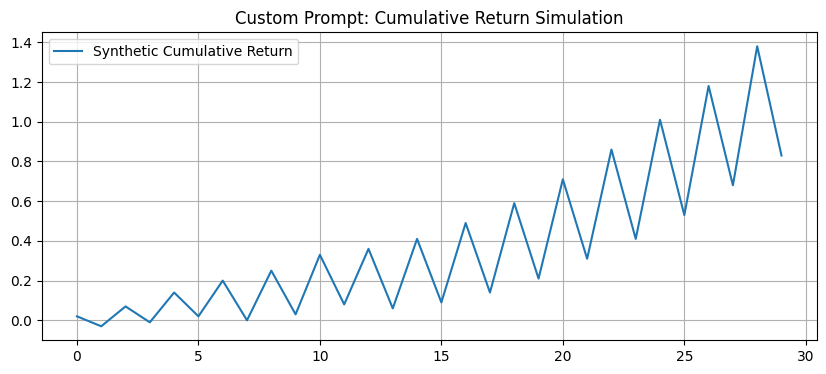

In [ ]:
try:
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": custom_prompt}],
        temperature=0.7,
        max_tokens=300,
    )
    generated_text = response.choices[0].message.content
    returns = parse_returns(generated_text)

    if returns and len(returns) >= 30:
        score = score_series(returns)
        print("Generated Returns Statistical Summary:", score)

        # Plot
        plt.figure(figsize=(10, 4))
        plt.plot(np.cumsum(returns), label="Synthetic Cumulative Return")
        plt.title("Custom Prompt: Cumulative Return Simulation")
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        print("Parsing failed or sequence too short.")

except Exception as e:
    print(f"Error during generation: {e}")


### Diagnostic Summary

Although the LLM generated a sequence with high volatility and large moves (suggesting it understood "high-risk" and "fat tails"), it failed to introduce **skewness**, resulting in a **too symmetric** distribution.

This validates that:
- LLMs can respond to certain keywords like “volatility” or “spikes”
- But phrases like “asymmetric” or “non-normal” require **more precise prompting** or **rule-based post-processing**

> In a business context, this supports the use of **reinforcement prompting** or **model-assisted correction loops** to ensure outputs meet domain-specific distributional standards.


##  Comprehensive Conclusion and Future Directions

This project explored how GPT-based Large Language Models (LLMs) can be used to generate synthetic financial return data. It demonstrated a full pipeline from prompt creation, generation, scoring, reinforcement prompting, and simulation — with business use cases like Monte Carlo-based risk modeling.

---

###  Is Synthetic Data as Good as Real Data?

While synthetic data offers flexibility and accessibility, it is **not yet a complete substitute for real financial data** — especially for:

- **Extreme event modeling** (e.g., crashes, black swan events)
- **High-frequency nuances** in return distributions
- **Asset-specific behavior** such as correlations and volatility clustering

In this project:
- Statistical comparisons (KS test, Q-Q plots, skew/kurtosis) showed that LLM-generated data lacked **fat tails and volatility**
- Only a small subset of samples passed all quality criteria
- This indicates that while synthetic data can **complement** real data, it **requires careful filtering and validation** before use in production models

---

###  Open-Source Alternatives: In-House Hugging Face Models

If avoiding proprietary APIs like OpenAI, consider these Hugging Face-compatible models:

| Model                         | Strengths                                       |
|------------------------------|--------------------------------------------------|
| `tiiuae/falcon-rw-1b`         | Lightweight, instruction-following              |
| `mistralai/Mistral-7B-Instruct`| Strong at structured output & code generation   |
| `mosaicml/mpt-7b-instruct`    | Good for local inference                        |
| `google/flan-t5-xl`           | Good zero-shot and prompt-completion quality    |
| `Salesforce/codegen-350M-mono`| Useful if generating Python-style simulation code|

> These can be hosted locally for cost control, privacy, or edge deployment.

---

###  Limitations of the Project

- **Prompt Compliance**: LLMs often failed to follow statistical constraints (e.g., target std or skew).
- **Fat Tail Generation**: Most synthetic series lacked realistic kurtosis or extreme return values.
- **Limited Sample Correction**: Reinforcement prompting improved only a few samples per round.
- **No Correlation Modeling**: This project only focused on univariate returns, not multi-asset behavior.
- **Lack of Domain Fine-Tuning**: GPT was not fine-tuned specifically on financial time series data.

---

###  Future Improvements and Extensions

1. **Model Fine-Tuning**  
   Train a small model (e.g., Mistral or T5) on real financial return sequences + prompt-response pairs.

2. **Prompt Scaffolding**  
   Use templates like:
   - “Return a list of 30 floats with std ≈ 0.03, skew < 0, and kurtosis > 3.”

3. **Hybrid Generation**  
   Combine GPT for qualitative structure with `numpy`/`scipy`-based random sampling (e.g., `np.random.standard_t(df=3)`).

4. **Multi-Asset Modeling**  
   Extend to generate synthetic data for multiple correlated assets using vector prompts or Copula post-processing.

5. **Use with RAG (Retrieval-Augmented Generation)**  
   Augment LLM responses with return segment retrieval from real data to boost grounding.

6. **Build a GUI or API**  
   Let business users describe market conditions in natural language, and receive synthetic data + risk plots automatically.
### 🧠 Financial Language Models: Domain-Specific Alternatives

While general-purpose models like GPT-3.5 are versatile, domain-specific financial LLMs trained on finance-focused corpora can offer better alignment for structured financial tasks.

---

#### Examples of Financial LLMs:

| Model             | Description & Use Case                                        |
|------------------|---------------------------------------------------------------|
| `yiyanghkust/finbert-pretrain` | Pretrained BERT on financial news — good for sentiment analysis |
| `FinGPT` (AI4Finance)          | Open-source GPT-like model trained on financial news, filings, tweets |
| `FinBERT-MC`                   | Extension for Monte Carlo simulation prompts, focused on risk phrases |
| `FinQANet` / `FinLang`         | Focused on QA and comprehension tasks in regulatory/compliance contexts |
| `FinCon (NeurIPS 2024)`        | Designed for decision-making tasks in finance, using reinforcement reasoning and data integration |

---

### Why We Used GPT for This Project

Despite the existence of financial-specific LLMs, we chose GPT-3.5 for these reasons:

- **Instruction-Following Superiority**: GPT-3.5 handles natural language prompts and correction loops better than most open-source models.
- **Scalability**: Capable of handling diverse prompt types (from price behaviors to Python code generation).
- **Ecosystem & API**: Seamlessly integrates with reinforcement prompting workflows and evaluation pipelines.
- **Quick Prototyping**: Ideal for proof-of-concept phases where access to real-time, stable models is critical.

---

### Future Consideration:

For more finance-specific language understanding (like regulatory context, analyst reports, earnings call transcripts), these models (FinBERT, FinCon) can be integrated into:

- **Risk classification systems**
- **Sentiment-aware return generation**
- **Document-driven scenario simulation (via RAG + LLM)**

> Ultimately, model choice depends on the task: for **generation and simulation**, general LLMs + scoring work well. For **interpretation and reasoning**, financial LLMs like FinCon or FinLang may offer superior results.

---

### Final Perspective

LLMs are not a drop-in replacement for historical data, but they **unlock new ways** to simulate, experiment, and ideate in finance — especially when combined with statistical rigor and prompt engineering.

> Synthetic data from LLMs, when properly scored and corrected, can enhance decision-making and risk assessment — especially in data-scarce or scenario-planning contexts.
